# PCA, ICA, and UMAP

- author: "Margaret Paiva"
- date: "2021/12/13"
- output: R notebook

## 1. Dependencies

In [1]:
# list of packages
x <- c('dplyr',
        'data.table',
        'tidyr',  
        'tibble',
        'tidyverse', 
        'ggplot2', 
        'viridis', 
        'umap', 
        'FactoMineR', 
        'fastICA')

In [2]:
# install packages
for (pkg in x) {
    if (!pkg %in% rownames(installed.packages())) {install.packages(pkg)}
}

In [3]:
# load packages
load_lib <- function(x) {
    suppressPackageStartupMessages(library(x, character.only = TRUE))
}
invisible(lapply(x, load_lib))

## 2. Request data from API
Request data from API using the files at https://github.com/Champions-Oncology/Workspaces/tree/main/1starter_data_request.

This notebook used the following options to request data:

(This notebook used [this example list of genes](https://github.com/Champions-Oncology/Workspaces/blob/main/gene_list.csv). You may define your genes of interest in a .csv file and use it in the data requesting file.)

- table="expression",
- cancer_type=["Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"],
- genes=list(genes_df['gene']),
- source = "PDX"
(For example, if you use the data_request.ipynb in Python, these are the options in the df, location = request_data() function.)

## 3. Data

In [4]:
# change to where you saved your .csv file and file name
df  <- fread("../data/pdx_expression_gene_list_multi_cancer.csv")
df$gene  <- as.character(df$gene)
df$log.tpm  <- as.numeric(df$log.tpm)
head(df, 2)
print(dim(df))

gene,model,model_name,log.tpm,z,fold,tumor_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ACSM3,CTG-3501,CTG-3501,2.7411490,-0.1693172,0.8765697,Breast
COPZ2,CTG-3501,CTG-3501,0.7995996,-0.9946150,0.1851744,Breast


[1] 82800     7


In [5]:
# Pivot the data
log_tpm <- df %>% 
    select(c('gene', 'model', 'log.tpm'))  %>% 
    pivot_wider(names_from = gene, values_from = log.tpm)  %>% 
    column_to_rownames('model')
log_tpm  <- log_tpm[complete.cases(log_tpm),]  # remove rows with missing values
log_tpm[1:2, 1:10]
print(dim(log_tpm))

,ACSM3,COPZ2,BZRAP1,CX3CL1,ETV1,ALDH3B1,ACPP,CHDH,CD74,FHL1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CTG-3501,2.741149,0.7995996,2.833298,4.224392,0.9328516,1.441369,2.463359,3.7351793,2.288166,0.9457198
CTG-0718,3.214430,4.1304615,2.401043,1.547657,3.9235433,2.984612,0.000000,0.4733435,5.082362,3.4499709


[1] 207 400


## 4.1 PCA

In [6]:
pca_out <- PCA(log_tpm)

In [7]:
# join the output with the original dataframe to have tumor_type
pca_plot <- data.frame(PC1 = pca_out$ind$coord[,1], 
                       PC2 = pca_out$ind$coord[,2], 
                       model = rownames(pca_out$ind$coord)) %>% 
    inner_join(df, by="model")

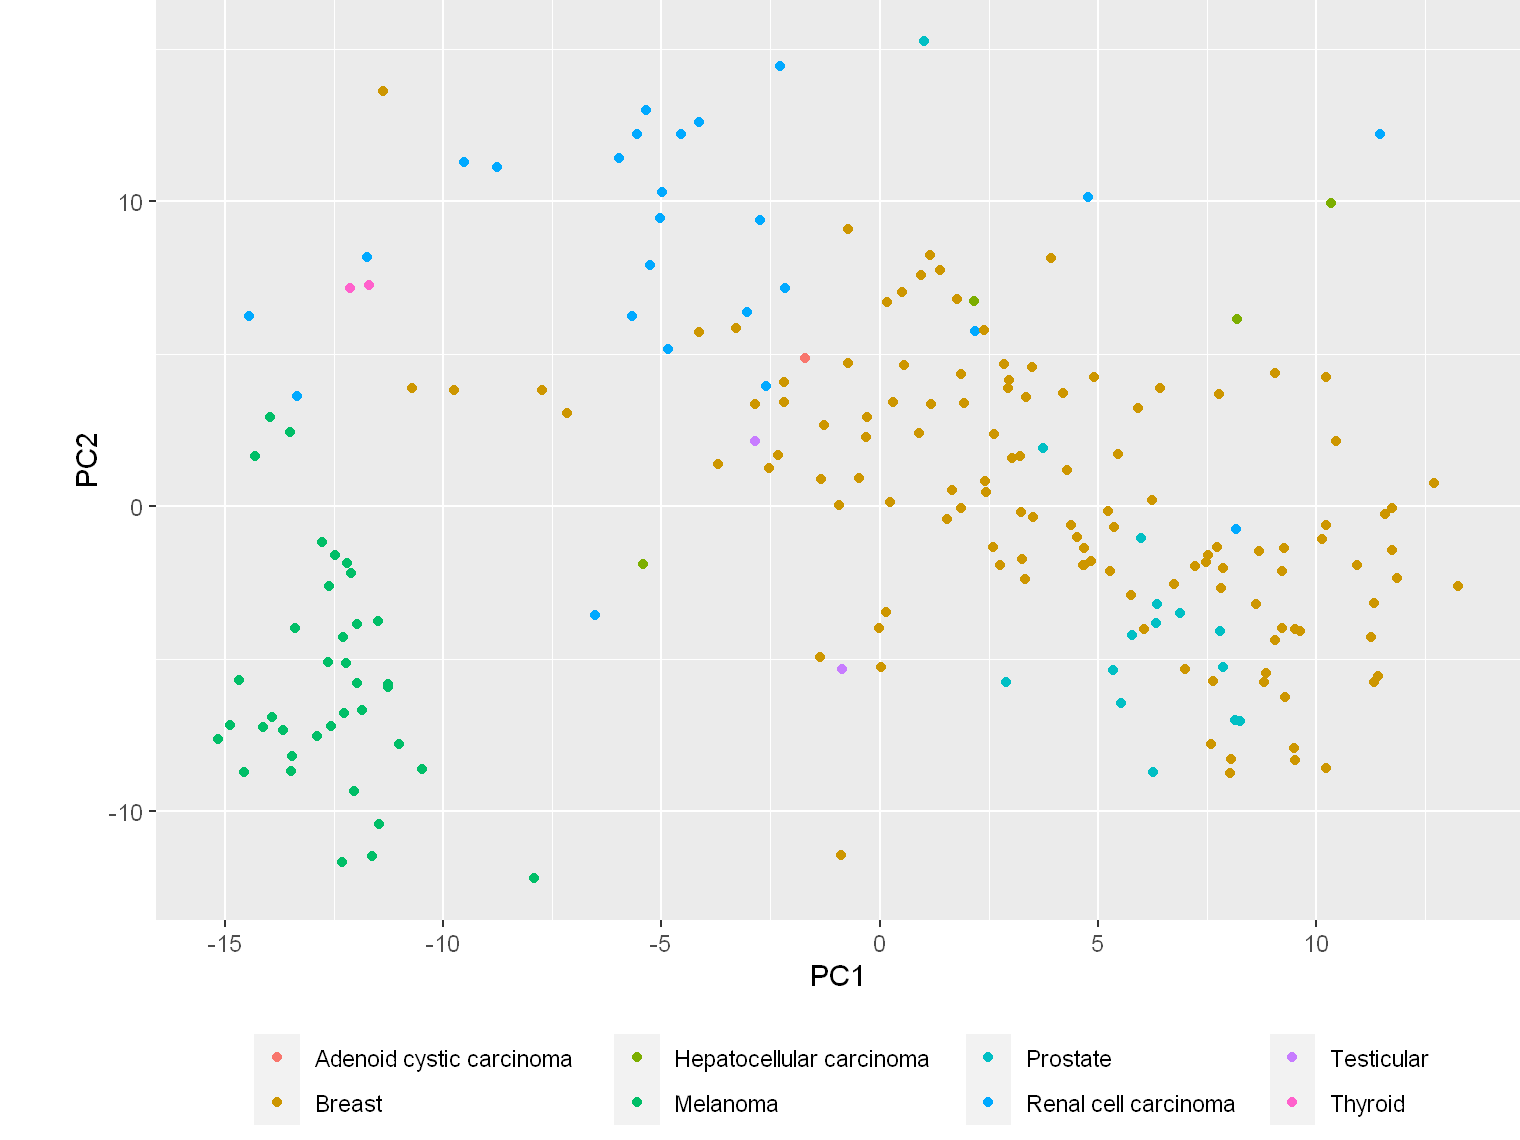

In [8]:
# plot
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res=190)  # set figure size
ggplot(pca_plot, aes(x = PC1, y = PC2)) + 
    geom_point(aes(color = tumor_type)) +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          plot.margin = unit(c(0,0,0,1), "cm"))

## 4.2 ICA

In [9]:
ica_out <- fastICA(log_tpm, 2)

In [10]:
# join the output with the original dataframe to have tumor_type
ica_plot <- data.frame(IC1 = ica_out$S[,1], 
                       IC2 = ica_out$S[,2], 
                        model = rownames(ica_out$S)) %>% 
    inner_join(df, by="model")

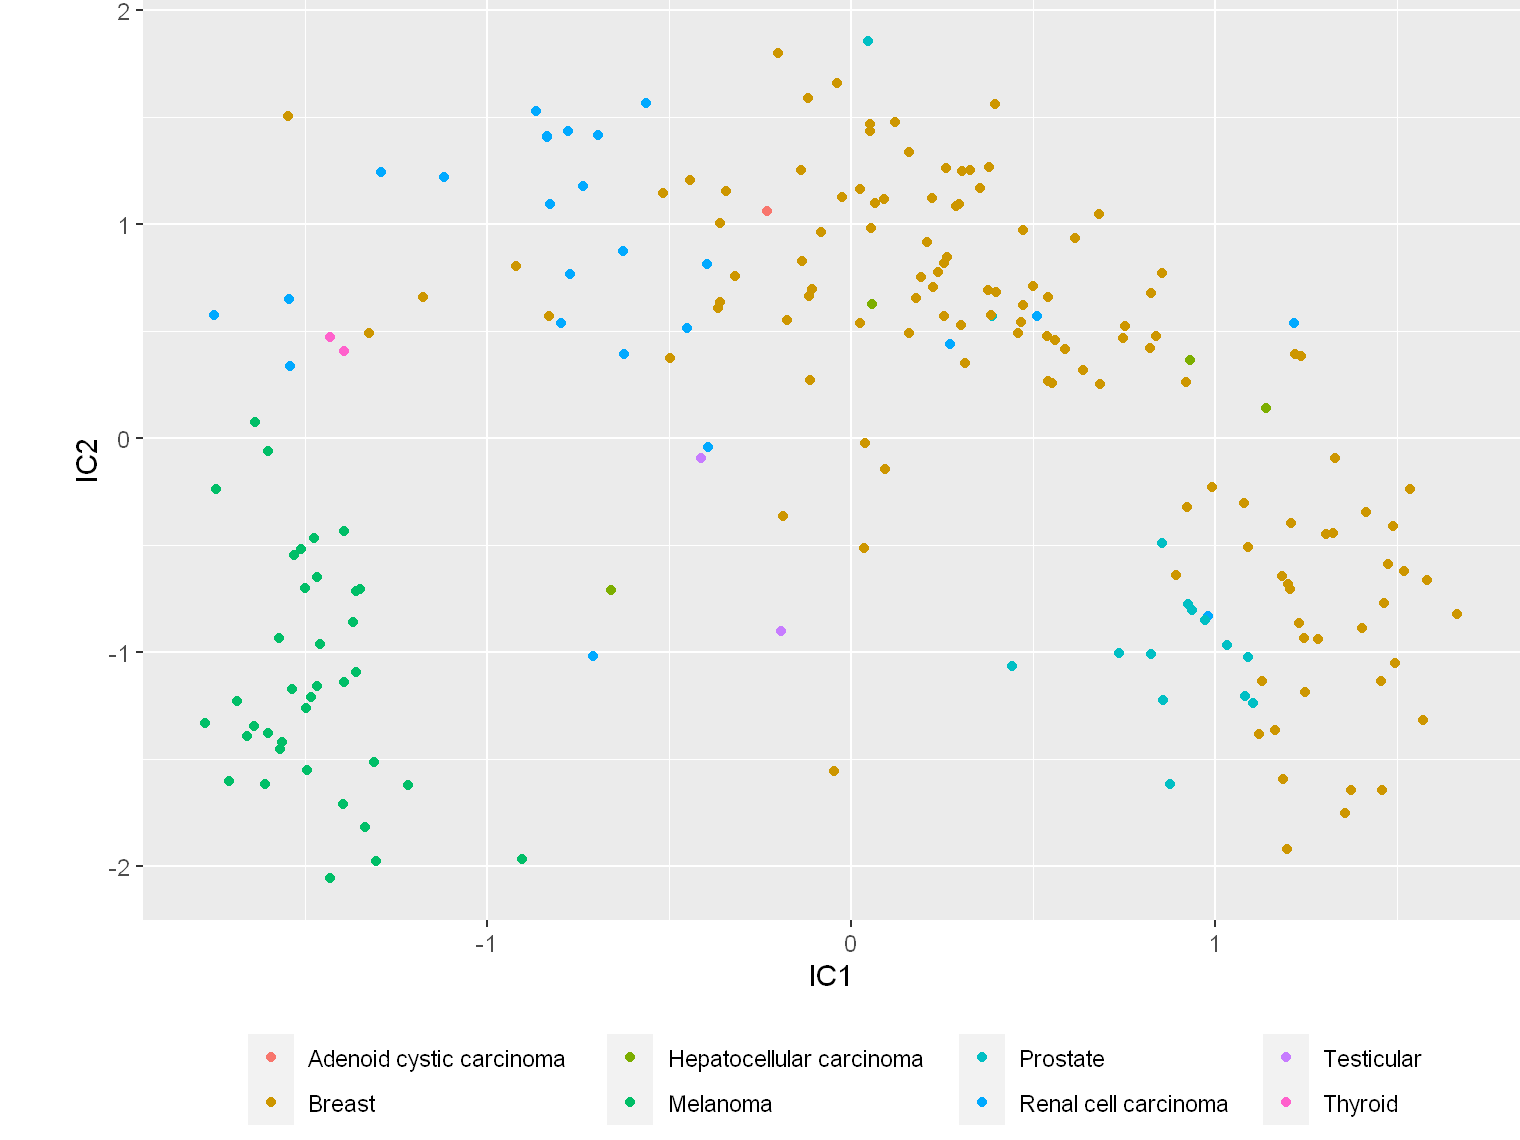

In [11]:
# plot
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res=190)  # set figure size
ggplot(ica_plot, aes(x = IC1, y = IC2)) + 
    geom_point(aes(color = tumor_type)) +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          plot.margin = unit(c(0,0,0,1), "cm"))

## 4.3 UMAP

In [12]:
umap_out <- umap(log_tpm)
umap_out

umap embedding of 207 items in 2 dimensions
object components: layout, data, knn, config



In [13]:
# join the output with the original dataframe to have tumor_type
umap_plot <- data.frame(UMAP1 = umap_out$layout[,1], 
                        UMAP2 = umap_out$layout[,2], 
                        model = rownames(umap_out$layout)) %>% 
    inner_join(df, by="model")

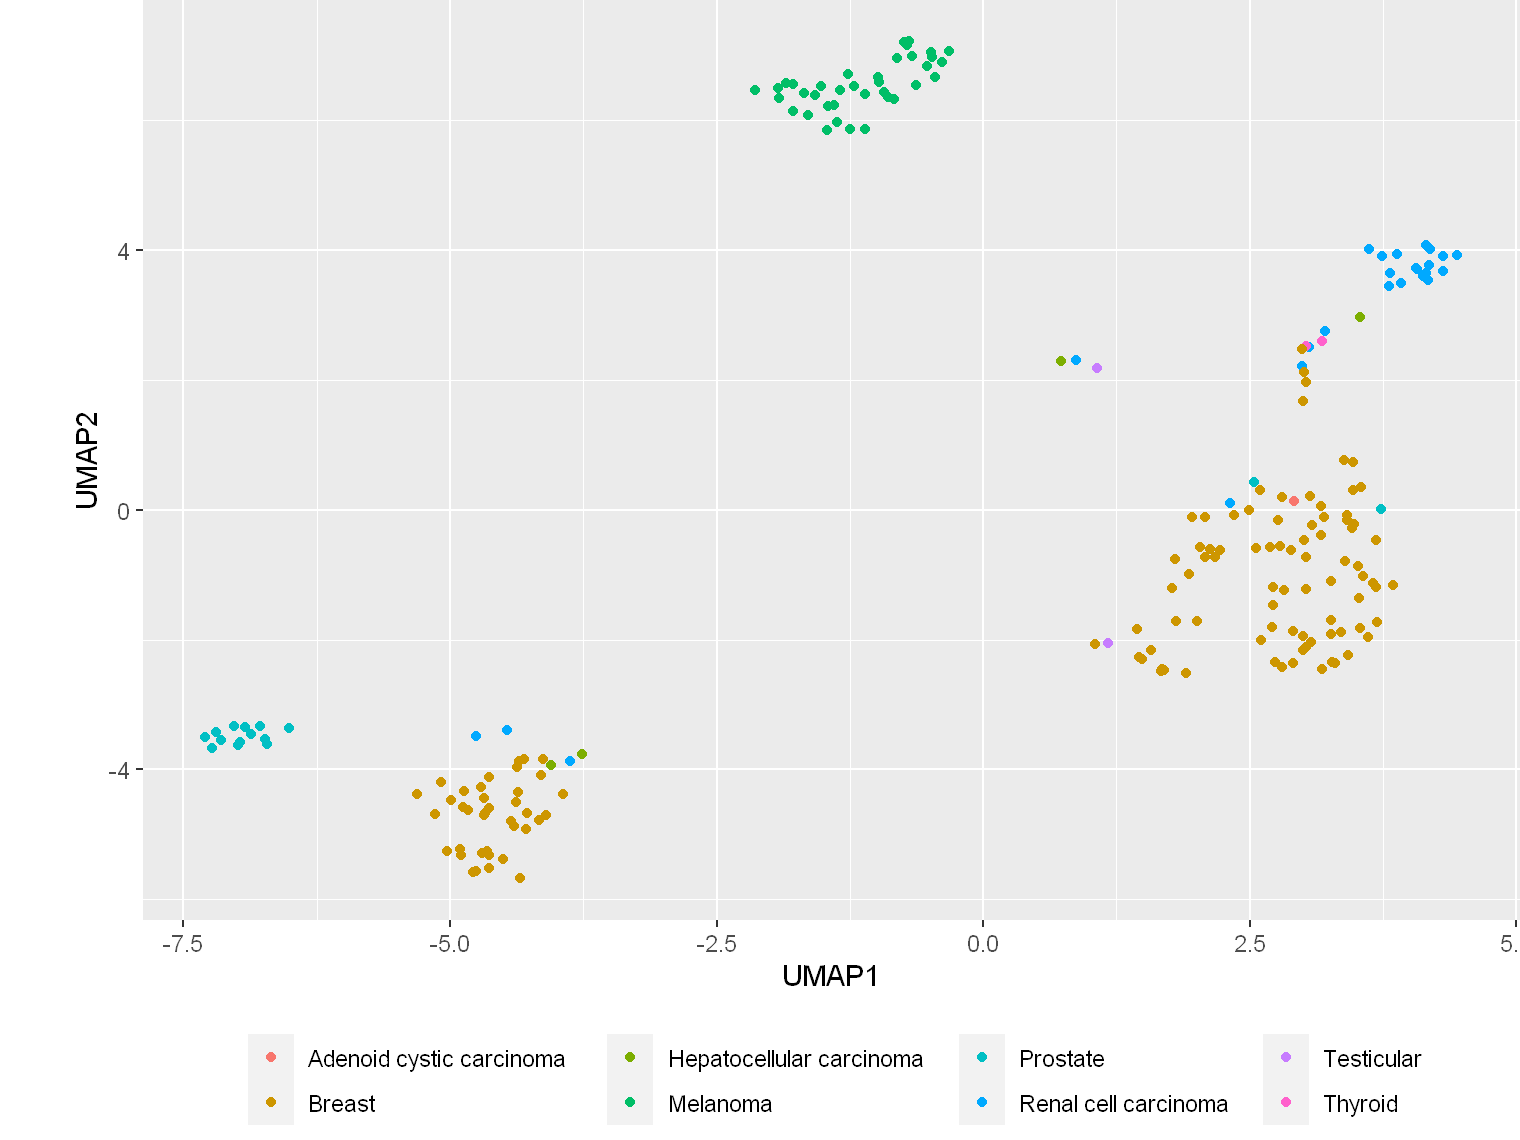

In [14]:
# plot
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res=190)  # set figure size
ggplot(umap_plot, aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = tumor_type)) +
    theme(legend.position = "bottom",
          legend.title = element_blank(),
          plot.margin = unit(c(0,0,0,1), "cm"))

# breast cancer are in two clusters because breast cancer has distinct subtypes